# Example of usage Spark OCR for Handwritten Text Recognition

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [6]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"
imagePath = "./data/handwritten/line.png"

In [11]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [12]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [13]:
#%pip install ../../python/dist/spark-ocr-3.6.0.spark30.tar.gz

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [19]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.0.3")
spark.sparkContext.setLogLevel("ERROR")

spark

Spark version: 3.0.2
Spark NLP version: 2.5.5
Spark OCR version: 3.6.0



## Read images and display it


    Image #0:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/line.png
    Resolution: 96 dpi
    Width: 511 px
    Height: 64 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


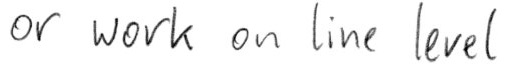

In [23]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [24]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(10)

pretrained_model = ("image_handwritten_text_recognition_IAM0724", "en", "public/ocr/models")
recoginzer = ImageHandwrittenTextRecognizer() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("handwritten_text")

pipeline = PipelineModel(stages=[
    binary_to_image,
    recoginzer
])

result = pipeline.transform(image_df)

image_handwritten_text_recognition_IAM0724 download started this may take some time.
Approximate size to download 44.9 MB
image_handwritten_text_recognition_IAM0724 download started this may take some time.
Approximate size to download 44.9 MB
Download done! Loading the resource.
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- exception: string (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- tmp_result: struct (nullable = true)
 |    |-- handwritten_text: string (nullable = true)
 |    |-- exception: string (nullable = true)



## Run pipeline and show results

In [25]:
result.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- handwritten_text: string (nullable = true)
 |-- exception: string (nullable = true)



In [26]:
result.select("handwritten_text").show(truncate=False)

+---------------------+
|handwritten_text     |
+---------------------+
|or wovk on line level|
+---------------------+



In [27]:
assert( result.count() > 0 )